In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from sklearn.ensemble import RandomForestClassifier

## Read in training data and label dictionary

### Define the data and label paths

In [2]:
# Training data file from previous step
data_path = "results/single_crops_merged_training_features_all_2021.txt"

# Dictionary with class labels from previous step
labels_path = "results/class_labels.json"

### Load the data and identify the feature columns for the model

In [3]:
# load the data
model_input = np.loadtxt(data_path)

# load the column_names
with open(data_path, "r") as file:
    header = file.readline()

# Remove comment symbol from header, then extract label and feature names
column_names = header.split()[1:]

label_col = column_names[0]
feature_cols = column_names[1:]

print(f"Label column:\n{label_col}\n")
print(f"Feature columns:\n{feature_cols}\n")

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

Label column:
label

Feature columns:
['blue_s2_Q4_2020', 'green_s2_Q4_2020', 'red_s2_Q4_2020', 'nir_s2_Q4_2020', 'swir_1_s2_Q4_2020', 'swir_2_s2_Q4_2020', 'red_edge_1_s2_Q4_2020', 'red_edge_2_s2_Q4_2020', 'red_edge_3_s2_Q4_2020', 'NDVI_s2_Q4_2020', 'LAI_s2_Q4_2020', 'SAVI_s2_Q4_2020', 'MSAVI_s2_Q4_2020', 'MNDWI_s2_Q4_2020', 'blue_s2_Q1_2021', 'green_s2_Q1_2021', 'red_s2_Q1_2021', 'nir_s2_Q1_2021', 'swir_1_s2_Q1_2021', 'swir_2_s2_Q1_2021', 'red_edge_1_s2_Q1_2021', 'red_edge_2_s2_Q1_2021', 'red_edge_3_s2_Q1_2021', 'NDVI_s2_Q1_2021', 'LAI_s2_Q1_2021', 'SAVI_s2_Q1_2021', 'MSAVI_s2_Q1_2021', 'MNDWI_s2_Q1_2021', 'blue_s2_Q3_2021', 'green_s2_Q3_2021', 'red_s2_Q3_2021', 'nir_s2_Q3_2021', 'swir_1_s2_Q3_2021', 'swir_2_s2_Q3_2021', 'red_edge_1_s2_Q3_2021', 'red_edge_2_s2_Q3_2021', 'red_edge_3_s2_Q3_2021', 'NDVI_s2_Q3_2021', 'LAI_s2_Q3_2021', 'SAVI_s2_Q3_2021', 'MSAVI_s2_Q3_2021', 'MNDWI_s2_Q3_2021', 'blue_s2_annual_2021', 'green_s2_annual_2021', 'red_s2_annual_2021', 'nir_s2_annual_2021', 'swir_

### Load the class labels dictionary

In [4]:
# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)
    
print(labels_dict)

{'Bean': 0, 'Boer bean': 1, 'Maize': 2, 'Nhemba bean': 3, 'Sesame': 4, 'Soy': 5}


## Convert model input into sklearn format

In [5]:
# Insert data into a Pandas DataFrame, then split into features and labels
model_input_df = pd.DataFrame(model_input, columns=column_names)
X = model_input_df.drop(label_col, axis=1)
y = model_input_df[[label_col]]

### Check data counts for each class

In [6]:
# Investigate value counts for each class
model_input_df[label_col].value_counts()

2.0    6668
4.0    4539
5.0     845
1.0     213
0.0      28
3.0      28
Name: label, dtype: int64

## Fit a Random Forest model for feature importance
This step is purely to investigate the feature importance in a Random Forest model, without any model optimisation. This step can be used to understand which features are predictive of the class label. From this, the feature list can be refined or expanded.

In [7]:
# Construct the model
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X, y.values.ravel());

### Display the features in ascending order of importance

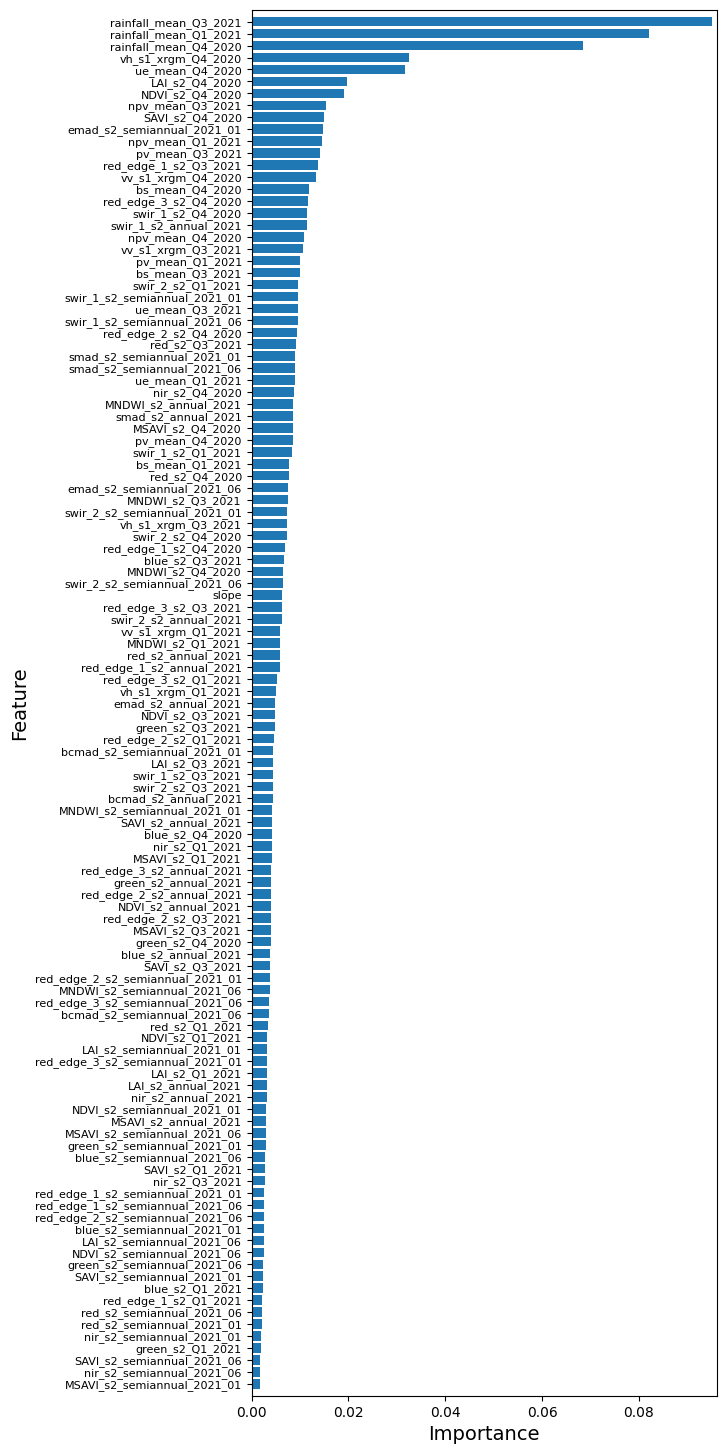

In [8]:
order = np.argsort(model.feature_importances_)

fig, ax = plt.subplots(figsize=(6, 18))
ax.barh(range(len(np.array(feature_cols)[order])), model.feature_importances_[order])
ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.set_yticks(np.arange(len(order)))
ax.set_yticklabels(np.array(feature_cols)[order], rotation=0, fontsize=8)
plt.ylim([-1,len(np.array(feature_cols)[order])])
plt.xlim(0, max(model.feature_importances_)+0.001)

plt.savefig("results/feature_importance.png", dpi=300, bbox_inches="tight", facecolor="white")

## Investigate correlation in features

In [9]:
correlation_matrix = X.corr().abs()
corr_threshold = 0.9

In [10]:
# # original method: remove all features with any correlation to others above threshold
# upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]
# print(len(to_drop),'features to be dropped:\n')
# print(to_drop)

# revised method: don't remove if highly correlated feature has already been added to removal list
# less features will be removed
to_drop = set() # set of features to drop
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if (correlation_matrix.iloc[i, j] >= corr_threshold) and (correlation_matrix.columns[j] not in to_drop):
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)
to_drop=list(to_drop)
print(len(to_drop),'features to be dropped:\n')
print(to_drop)

57 features to be dropped:

['red_edge_3_s2_Q3_2021', 'MSAVI_s2_annual_2021', 'MSAVI_s2_semiannual_2021_06', 'red_edge_2_s2_annual_2021', 'LAI_s2_Q4_2020', 'swir_1_s2_annual_2021', 'swir_2_s2_semiannual_2021_06', 'LAI_s2_semiannual_2021_06', 'MSAVI_s2_Q4_2020', 'SAVI_s2_Q1_2021', 'swir_2_s2_Q1_2021', 'NDVI_s2_semiannual_2021_06', 'MNDWI_s2_semiannual_2021_06', 'red_edge_2_s2_Q4_2020', 'SAVI_s2_semiannual_2021_06', 'swir_2_s2_Q4_2020', 'green_s2_Q1_2021', 'swir_2_s2_annual_2021', 'green_s2_Q4_2020', 'red_edge_1_s2_Q4_2020', 'red_edge_2_s2_Q1_2021', 'green_s2_Q3_2021', 'red_edge_3_s2_semiannual_2021_01', 'MSAVI_s2_semiannual_2021_01', 'red_edge_2_s2_semiannual_2021_06', 'red_s2_semiannual_2021_06', 'swir_1_s2_semiannual_2021_06', 'red_edge_2_s2_Q3_2021', 'red_edge_3_s2_semiannual_2021_06', 'red_edge_3_s2_annual_2021', 'LAI_s2_semiannual_2021_01', 'MSAVI_s2_Q3_2021', 'swir_2_s2_semiannual_2021_01', 'green_s2_semiannual_2021_06', 'swir_2_s2_Q3_2021', 'NDVI_s2_annual_2021', 'green_s2_annual

In [11]:
df1 = X.drop(to_drop, axis=1)

print("Remaining columns after removing correlated features")
print(df1.columns)

Remaining columns after removing correlated features
Index(['blue_s2_Q4_2020', 'red_s2_Q4_2020', 'nir_s2_Q4_2020',
       'swir_1_s2_Q4_2020', 'NDVI_s2_Q4_2020', 'MNDWI_s2_Q4_2020',
       'blue_s2_Q1_2021', 'red_s2_Q1_2021', 'nir_s2_Q1_2021',
       'swir_1_s2_Q1_2021', 'red_edge_1_s2_Q1_2021', 'NDVI_s2_Q1_2021',
       'LAI_s2_Q1_2021', 'MNDWI_s2_Q1_2021', 'blue_s2_Q3_2021',
       'red_s2_Q3_2021', 'nir_s2_Q3_2021', 'swir_1_s2_Q3_2021',
       'NDVI_s2_Q3_2021', 'MNDWI_s2_Q3_2021', 'blue_s2_annual_2021',
       'red_edge_1_s2_annual_2021', 'smad_s2_annual_2021',
       'emad_s2_annual_2021', 'bcmad_s2_annual_2021', 'LAI_s2_annual_2021',
       'MNDWI_s2_annual_2021', 'blue_s2_semiannual_2021_01',
       'red_s2_semiannual_2021_01', 'nir_s2_semiannual_2021_01',
       'swir_1_s2_semiannual_2021_01', 'red_edge_1_s2_semiannual_2021_01',
       'smad_s2_semiannual_2021_01', 'emad_s2_semiannual_2021_01',
       'NDVI_s2_semiannual_2021_01', 'MNDWI_s2_semiannual_2021_01',
       'vv_s1_xr

In [12]:
# Construct the model
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(df1, y.values.ravel());

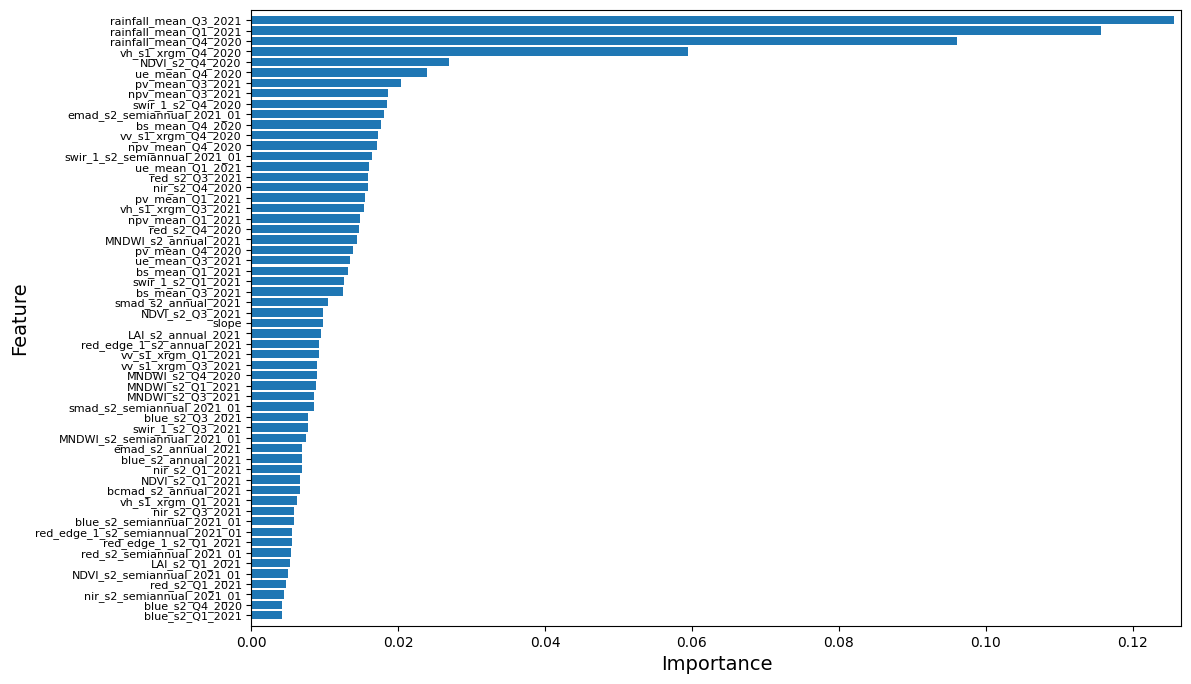

In [13]:
order = np.argsort(model.feature_importances_)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(np.array(df1.columns)[order])), model.feature_importances_[order])
ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.set_yticks(np.arange(len(order)))
ax.set_yticklabels(np.array(df1.columns)[order], rotation=0, fontsize=8)
plt.ylim([-1,len(np.array(df1.columns)[order])])
plt.xlim(0, max(model.feature_importances_)+0.001)

fig.savefig(f"results/feature_importance_afterremovecorrelation.png", dpi=300, bbox_inches="tight", facecolor="white")